In [1]:
import numpy as np
import awkward as ak
import warnings
import matplotlib.pyplot as plt
import hist
import math
import os
import json
import gc
import dask_awkward as dak
import mplhep as hep
from scipy.stats import kstest

In [2]:
plt.style.use(hep.style.CMS)

In [3]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'divide by')
warnings.filterwarnings('ignore', 'overflow encountered')
warnings.filterwarnings('ignore', 'Conversion of an array')

In [4]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [5]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [6]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [7]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [8]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/keep*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/keep*', columns=columns)
            else:
                continue
    return output

In [9]:
def add_ratio(ratio, dataframe):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:])
    num_ecf = dataframe[numerator]
    den_ecf = dataframe[denominator]
    ecf_ratio = (num_ecf / (den_ecf**exponent))   
    return ecf_ratio

In [10]:
def get_num_den(ratio):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]  
    return (numerator, denominator)

In [11]:
def firsts(mc):
    for i in mc:
        if type(mc[i]) == dict:
            for j in mc[i]:
                for k in mc[i][j].fields:
                    if 'event' in k:
                        continue
                    else:
                        try:
                            mc[i][j][k] = ak.firsts(mc[i][j][k])
                        except:
                            continue
        else:
            for j in mc[i].fields:
                if 'event' in j:
                    continue
                else:
                    try:
                        mc[i][j] = ak.firsts(mc[i][j])
                    except:
                        continue
    return mc

In [12]:
ecf_list = dak.from_parquet('/cms/cephfs/data/store/user/cmoore24/skims/old/full_skims/nolepton/mc/hgg/new*').groomed_ecfs.fields

In [13]:
ratios = []
for i in range(len(ecf_list)):
    if ecf_list[i][2] == 'e':
        n1 = int(ecf_list[i][3])
        a = int(ecf_list[i][:2])
    else:
        n1 = int(ecf_list[i][2])
        a = int(ecf_list[i][0])
    for j in range(len(ecf_list)):
        if ecf_list[i] == ecf_list[j]:
            continue
        if ecf_list[j][2] == 'e':
            n2 = int(ecf_list[j][3])
            b = int(ecf_list[j][:2])
        else:
            n2 = int(ecf_list[j][2])
            b = int(ecf_list[j][0])
        if n1 < n2:
            continue
        else:
            beta1 = float(ecf_list[i][-2:])
            beta2 = float(ecf_list[j][-2:])
            exponent = (a * beta1) / (b * beta2)
            ratios.append(f'{ecf_list[i]}/{ecf_list[j]}**{exponent}')

In [14]:
len(ratios)

17312

In [15]:
upper = 1000
lower = 475
IL = 41.5

In [16]:
def ecf_hist(dataset, ecf_min, ecf_max):
    make_hist = hist.Hist.new.Reg(40, ecf_min, ecf_max, name='ECF', label='MC ECF', underflow=False, overflow=False).Weight()
    make_hist.fill(ECF=dataset)
    return make_hist

In [17]:
# ratio = ratios[1000]
ratio = '3e520/1e220**3.0'

In [18]:
groom_choice = 'groomed'

In [19]:
numerator, denominator = get_num_den(ratio)
numerator, denominator

('3e520', '1e220')

In [20]:
path = '/cms/cephfs/data/store/user/cmoore24/skims/full_skims/trijet/mc/2017'
columns=['goodjets.msoftdrop', 'goodjets.pt', 'goodjets.trigger_mask', (f"{groom_choice}_ecfs", f'{numerator}'), (f"{groom_choice}_ecfs", f'{denominator}')]
mc = read_files(f'{path}')

In [21]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']

In [22]:
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])
# del(mc['qcd_300to470'])

In [23]:
mc = firsts(mc)

In [24]:
path = '/cms/cephfs/data/store/user/cmoore24/skims/full_skims/trijet/data/2017'
data = read_files(f'{path}')
data = firsts(data)

In [25]:
mc['qcd_470to600'].fields

['goodjets', 'groomed_ecfs']

In [26]:
for i in xsecs:
    try:
        if type(mc[i]) == dict:
            for j in mc[i]:
                mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper) &
                        (mc[i][j].goodjets.msoftdrop >= 80) & (mc[i][j].goodjets.msoftdrop <= 170)
                       & (mc[i][j].goodjets.trigger_mask) )
                mc[i][j] = mc[i][j][mask]
        else:
            mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper) &
                        (mc[i].goodjets.msoftdrop >= 80) & (mc[i].goodjets.msoftdrop <= 170)
                    & (mc[i].goodjets.trigger_mask))
            mc[i] = mc[i][mask]
    except:
        continue

In [27]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper) &
                        (data[i][j].goodjets.msoftdrop >= 80) & (data[i][j].goodjets.msoftdrop <= 170)
                    & (data[i][j].goodjets.trigger_mask))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper) &
                        (data[i].goodjets.msoftdrop >= 80) & (data[i].goodjets.msoftdrop <= 170)
                 & (data[i].goodjets.trigger_mask))
        data[i] = data[i][mask]

In [28]:
data_s = {}
for i in data:
    if "Jet" in i:
        data_s[i] = data[i]  
data_arr = ak.concatenate([data[i] for i in data_s])

In [29]:
data_ratio = add_ratio(ratio, data_arr[f'{groom_choice}_ecfs'])

In [30]:
mc_ratios = {}
for i in mc:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mc_ratios[j] = add_ratio(ratio, mc[i][j][f'{groom_choice}_ecfs'])
    else:
        mc_ratios[i] = add_ratio(ratio, mc[i][f'{groom_choice}_ecfs'])

In [31]:
data_ratio = data_ratio[~ak.is_none(ak.nan_to_none(data_ratio))]

In [32]:
for i in mc_ratios:
    mc_ratios[i] = mc_ratios[i][~ak.is_none(ak.nan_to_none(mc_ratios[i]))]

In [33]:
def build_weighted_ks_input(mc, data, xsecs, totals, lumi):
    sim_values = []
    sim_weights = []
    
    for sample, arr in mc.items():
        if len(arr) == 0 or sample not in xsecs or sample not in totals:
            continue
        
        xsec = xsecs[sample]
        nevt = totals[sample]
        weight = (xsec * lumi) / nevt

        score_vals = ak.to_numpy(arr)
        sim_values.append(score_vals)
        sim_weights.append(np.full(len(score_vals), weight))


    sim_values = np.concatenate(sim_values)
    sim_weights = np.concatenate(sim_weights)

    data_values = []

    vals = ak.to_numpy(data)
    data_values.append(vals)
    data_values = np.concatenate(data_values)

    return data_values, sim_values, sim_weights

In [34]:
def make_weighted_ecdf(values, weights):
    sorter = np.argsort(values)
    sorted_vals = values[sorter]
    sorted_weights = weights[sorter]
    cumsum = np.cumsum(sorted_weights)
    cdf_vals = cumsum / cumsum[-1]

    def cdf_func(x):
        return np.interp(x, sorted_vals, cdf_vals, left=0.0, right=1.0)

    return cdf_func

In [35]:
# Run the KS test
data_vals, sim_vals, sim_wts = build_weighted_ks_input(mc_ratios, data_ratio, xsecs, totals, IL)
cdf_sim = make_weighted_ecdf(sim_vals, sim_wts)
ks_result = kstest(data_vals, cdf=cdf_sim)

print("KS Test Statistic:", ks_result.statistic)
print("KS Test p-value:", ks_result.pvalue)

KS Test Statistic: 0.0016593888839663284
KS Test p-value: 2.9946346837163076e-05


In [36]:
ratio_min = ak.min(data_ratio)
ratio_max = ak.max(data_ratio)

In [37]:
-math.log10(ks_result.statistic)

2.7800518235180673

In [38]:
hists = {}
for i in mc:
    if type(mc[i]) == dict:
        hists[i] = {}
        for j in mc[i]:
            hists[i][j] = ecf_hist(mc_ratios[i][j], ratio_min, ratio_max)
    else:
        hists[i] = ecf_hist(mc_ratios[i], ratio_min, ratio_max)

In [39]:
for i in mc:
    scale = ((IL*(xsecs[i]*1000))/(totals[i]))
    hists[i].view(flow=True)[:] *= scale

mc_hist = sum(hists[i] for i in hists)

In [40]:
data_hist = hist.Hist.new.Reg(40, ratio_min, ratio_max, name='Ratio', label='Data Ratio', underflow=False, overflow=False).Weight()
data_hist.fill(Ratio=data_ratio);

In [41]:
mc_values, mc_bins = mc_hist.to_numpy()
data_values, data_bins = data_hist.to_numpy()
mc_density = mc_values / mc_values.sum()
data_density = data_values / data_values.sum()
mc_cdf = np.cumsum(mc_density)
data_cdf = np.cumsum(data_density)
ks_statistic = np.max(np.abs(mc_cdf - data_cdf))
adjusted = -math.log10(ks_statistic)
adjusted

2.783731498323322

In [42]:
# mc_hist.plot1d(label='Hist MC', density=True, yerr=False)
# data_hist.plot1d(label='Hist Data', density=True, yerr=False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# # plt.hist(sim_vals, bins=40, histtype='step', density=True, label='Weight MC', weights=sim_wts, range=(np.min(data_vals), np.max(data_vals)))
# # plt.hist(data_vals, bins=40, histtype='step', density=True, label='Weight Data', range=(np.min(data_vals), np.max(data_vals)))
# plt.legend()
# plt.xlabel(r'$\dfrac{{}_3e_5^{2.0}}{\left({}_1e_2^{2.0}\right)^{3.0}}$', loc='center')
# plt.show()

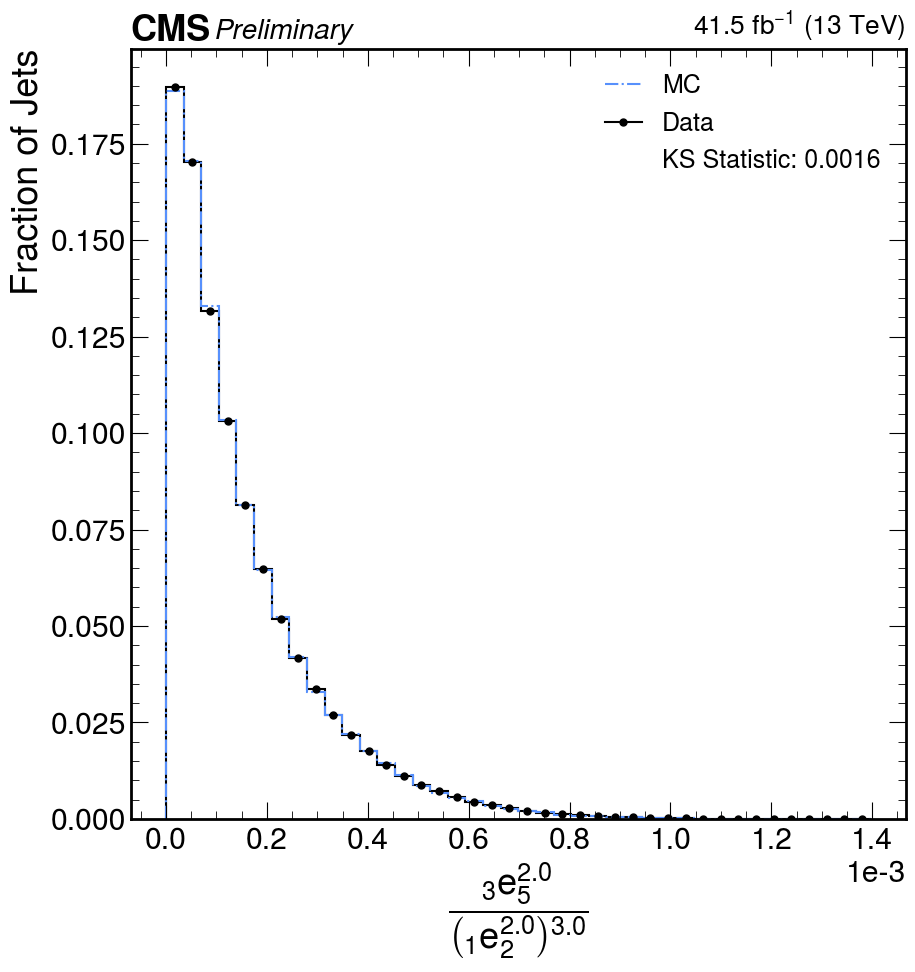

In [43]:
# Normalize both hist.Hist objects manually
from matplotlib.lines import Line2D
from hist.intervals import poisson_interval

mc_hist_norm = mc_hist / mc_hist.values().sum()
data_hist_norm = data_hist / data_hist.values().sum()

# Plot normalized histograms
mc_hist_norm.plot1d(label='MC', yerr=False, linestyle='-.', zorder=1)
data_hist_norm.plot1d(label='Data', yerr=False, color='k', zorder=0)


edges = data_hist.axes[0].edges
centers = 0.5 * (edges[1:] + edges[:-1])
width = edges[1] - edges[0]  # Assumes uniform binning, e.g. 0.05
y = data_hist.values()

# Calculate Poisson intervals
yerr_poisson = np.abs(poisson_interval(y) - y)

# Normalize y and yerr
norm = np.sum(y)
y_norm = y / norm
yerr_norm = np.abs(poisson_interval(y) - y) / norm  # no / width

# Plot points with error bars
plt.errorbar(centers, y_norm, yerr=[yerr_norm[0], yerr_norm[1]], fmt='o', color='k', markersize=5)


# Scientific tick formatting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Axis label and legend
plt.xlabel(r'$\dfrac{{}_3e_5^{2.0}}{\left({}_1e_2^{2.0}\right)^{3.0}}$', loc='center')
plt.ylabel('Fraction of Jets')
custom_text = Line2D([0], [0], color='none', label='KS Statistic: 0.0016')

custom_lines = [
    Line2D([0], [0], color='C0', linestyle='-.'),
    Line2D([0], [0], color='k', linestyle='-', marker='o', markersize=5),
    Line2D([0], [0], color='none'),
]

# Custom legend with extra entry
plt.legend(custom_lines, ['MC', 'Data', 'KS Statistic: 0.0016'], fontsize=18)

hep.cms.label('Preliminary', lumi=41.5, fontsize=20, data=True)
plt.show()

In [44]:
ks_result

KstestResult(statistic=np.float64(0.0016593888839663284), pvalue=np.float64(2.9946346837163076e-05), statistic_location=np.float64(0.00048391643209753693), statistic_sign=np.int8(-1))

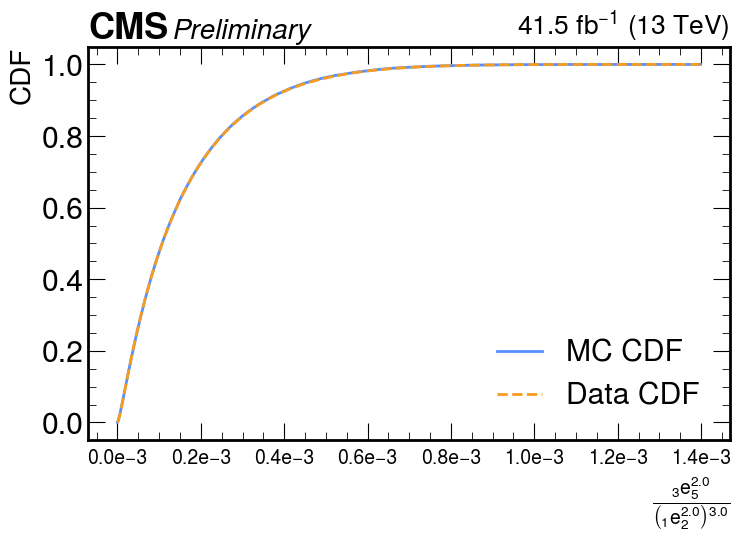

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_vals[:960], sim_cdf_vals[:960], label='MC CDF', linewidth=2)
ax.step(data_sorted, data_cdf, label='Data CDF', where='post', linewidth=2, linestyle='--')

ax.set_xlabel(r'$\dfrac{{}_3e_5^{2.0}}{\left({}_1e_2^{2.0}\right)^{3.0}}$', fontsize=14)
ax.set_ylabel('CDF', fontsize=20)

# ✅ custom formatter so every tick shows value in e-3
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*1e3:.1f}e−3"))

# ✅ explicitly set ticks
ax.set_xticks(np.arange(0, 1.6e-3, 2e-4))
ax.tick_params(axis='x', labelsize=14)

ax.legend()
hep.cms.label('Preliminary', lumi='41.5', data=True, fontsize=20, ax=ax)

plt.tight_layout()
plt.show()
plt.close(fig)

In [46]:
len(x_vals)

1000

In [47]:
len(sim_cdf_vals)

1000

In [ ]:
def sample_from_weighted_cdf(values, weights, size):
    weights = weights / np.sum(weights)
    return np.random.choice(values, size=size, replace=True, p=weights)

observed_stat = kstest(data_vals, cdf=make_weighted_ecdf(sim_vals, sim_wts)).statistic

# Bootstrap
n_bootstrap = 10
boot_stats = []
for _ in range(n_bootstrap):
    sample = sample_from_weighted_cdf(sim_vals, sim_wts, size=len(data_vals))
    cdf_sample = make_weighted_ecdf(sample, np.ones_like(sample))
    stat = kstest(data_vals, cdf=cdf_sample).statistic
    boot_stats.append(stat)

boot_stats = np.array(boot_stats)
p_value = np.sum(boot_stats >= observed_stat) / len(boot_stats)

In [ ]:
import numpy as np
from scipy.stats import kstest
from joblib import Parallel, delayed

def compute_stat(sample):
    cdf = make_weighted_ecdf(sample, np.ones_like(sample))
    return kstest(data_vals, cdf).statistic

n_bootstrap = 5000

# Batched sample generation
bootstrap_samples = np.random.choice(
    sim_vals,
    size=(n_bootstrap, len(data_vals)),
    replace=True,
    p=sim_wts / np.sum(sim_wts)
)

# Parallel KS stat computation
boot_stats = Parallel(n_jobs=-1)(
    delayed(compute_stat)(bootstrap_samples[i]) for i in range(n_bootstrap)
)
p_value = np.sum(boot_stats >= observed_stat) / len(boot_stats)

In [ ]:
p_value

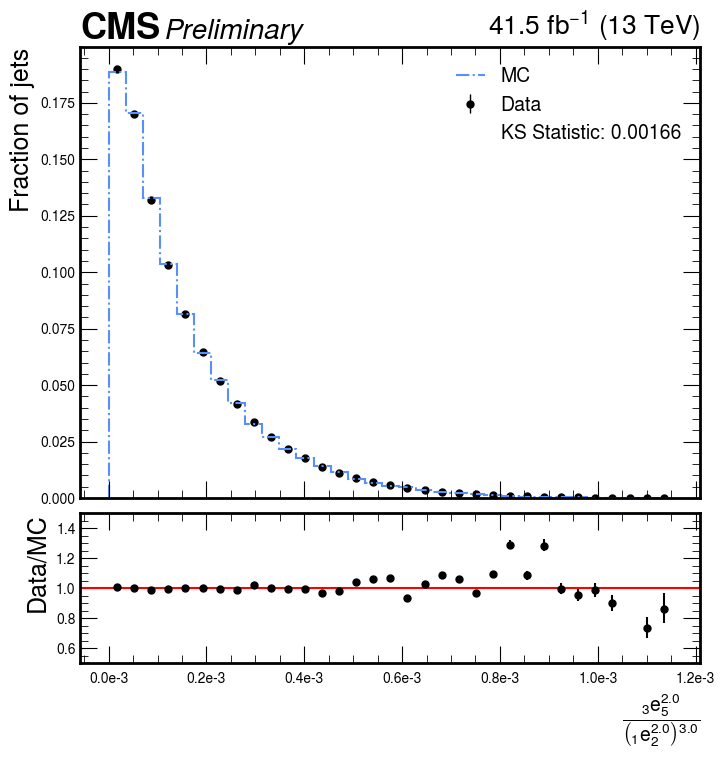

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import mplhep as hep
from matplotlib.lines import Line2D
from hist.intervals import poisson_interval
from matplotlib.ticker import FuncFormatter

mc_hist = mc_hist[:33]
data_hist = data_hist[:33]

# Normalize histograms
mc_vals = mc_hist.values(flow=False)
data_vals = data_hist.values(flow=False)
mc_norm = mc_vals / mc_vals.sum()
data_norm = data_vals / data_vals.sum()

mc_hist_norm = mc_hist / mc_vals.sum()
data_hist_norm = data_hist / data_vals.sum()

edges = data_hist.axes[0].edges
centers = 0.5 * (edges[1:] + edges[:-1])
widths = edges[1:] - edges[:-1]

# Errors on data (Poisson, normalized)
yerr_poisson = poisson_interval(data_vals)
data_err = np.abs(yerr_poisson - data_vals)
data_err_norm = data_err / data_vals.sum()

# --- Create figure with ratio plot ---
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

# --- Upper plot ---
ax0 = fig.add_subplot(gs[0])
hep.cms.label('Preliminary', lumi=41.5, fontsize=20, data=True, ax=ax0)

mc_hist_norm.plot1d(label='MC', yerr=False, linestyle='-.', zorder=1, ax=ax0)
data_hist_norm.plot1d(label='Data', color='k', zorder=0, ax=ax0, histtype='errorbar')
# ax0.errorbar(centers, data_norm, yerr=data_err_norm, fmt='o', color='k', markersize=5, zorder=0)


ax0.set_ylabel('Fraction of jets', fontsize=18)
ax0.set_xlabel('')
ax0.tick_params(labelbottom=False)  # Only hides label, keeps ticks
ax0.tick_params(axis='both', labelsize=10)
text_entry = Line2D([], [], color='none', label='Additional info or notes')

# Add to legend with existing handles
handles, labels = ax0.get_legend_handles_labels()
handles.append(text_entry)
labels.append('KS Statistic: 0.00166')

ax0.legend(handles=handles, labels=labels, fontsize=14)

# --- Lower plot ---
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# Avoid division by zero
ratio = np.divide(data_norm, mc_norm, out=np.zeros_like(data_norm), where=mc_norm != 0)
ratio_err = np.divide(data_err_norm, mc_norm, out=np.zeros_like(data_err_norm), where=mc_norm != 0)

ax1.axhline(1.0, color='r', linestyle='-')
ax1.errorbar(centers, ratio, yerr=ratio_err, fmt='o', color='k', markersize=5)

sci_formatter = FuncFormatter(lambda x, _: f"{x*1e3:.1f}e-3")
ax1.xaxis.set_major_formatter(sci_formatter)
ax0.xaxis.set_major_formatter(sci_formatter)

ax1.set_xlabel(r'$\dfrac{{}_3e_5^{2.0}}{\left({}_1e_2^{2.0}\right)^{3.0}}$', fontsize=14)
ax1.set_ylabel('Data/MC', fontsize=18)
ax1.set_ylim(0.5, 1.5)
# ax1.grid(True, which='both', axis='y', linestyle=':', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=10)

plt.show()
